In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/tomato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 551M/551M [00:31<00:00, 18.6MB/s]


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/train",
    label_mode="categorical",
    class_names=['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato/Tomato/valid",
    label_mode="categorical",
    class_names=['Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf healthy', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 17195 files belonging to 9 classes.
==========================Validation Data====================
Found 4197 files belonging to 9 classes.


In [6]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("tomato/Tomato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("tomato/Tomato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 17195 images belonging to 9 classes.
Found 4197 images belonging to 9 classes.


In [ ]:
# Check GPU
!nvidia-smi

Tue Jun  6 09:13:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

DenseNet Model 1

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Tomato_DenseNet_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 7,302,217
Trainable params: 7,218,569
Non-t

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.8187
Epoch 1: val_accuracy improved from -inf to 0.89397, saving model to Tomato_DenseNet_model1_Based_Augmented


860/860 [==============================] - 476s 455ms/step - loss: 0.6376 - accuracy: 0.8187 - val_loss: 0.3582 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9088
Epoch 2: val_accuracy did not improve from 0.89397
860/860 [==============================] - 325s 377ms/step - loss: 0.2759 - accuracy: 0.9088 - val_loss: 0.6972 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9215
Epoch 3: val_accuracy did not improve from 0.89397
860/860 [==============================] - 328s 381ms/step - loss: 0.2404 - accuracy: 0.9215 - val_loss: 0.5954 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9271
Epoch 4: val_accuracy did not improve from 0.89397
860/860 [==============================] - 325s 378ms/step - loss: 0.2261 - accuracy: 0.9271 - val_loss: 0.7179 

860/860 [==============================] - 383s 446ms/step - loss: 0.2001 - accuracy: 0.9338 - val_loss: 0.3368 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 6/100
860/860 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9374
Epoch 6: val_accuracy improved from 0.89850 to 0.93662, saving model to Tomato_DenseNet_model1_Based_Augmented


860/860 [==============================] - 376s 437ms/step - loss: 0.1878 - accuracy: 0.9374 - val_loss: 0.1816 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 7/100
860/860 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9418
Epoch 7: val_accuracy did not improve from 0.93662
860/860 [==============================] - 315s 366ms/step - loss: 0.1747 - accuracy: 0.9418 - val_loss: 0.2596 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 8/100
860/860 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9423
Epoch 8: val_accuracy improved from 0.93662 to 0.94853, saving model to Tomato_DenseNet_model1_Based_Augmented


860/860 [==============================] - 375s 435ms/step - loss: 0.1768 - accuracy: 0.9423 - val_loss: 0.1494 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 9/100
860/860 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9436
Epoch 9: val_accuracy did not improve from 0.94853
860/860 [==============================] - 318s 370ms/step - loss: 0.1707 - accuracy: 0.9436 - val_loss: 0.3225 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 10/100
860/860 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9488
Epoch 10: val_accuracy did not improve from 0.94853
860/860 [==============================] - 321s 373ms/step - loss: 0.1539 - accuracy: 0.9488 - val_loss: 0.4349 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 11/100
860/860 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9517
Epoch 11: val_accuracy did not improve from 0.94853
860/860 [==============================] - 321s 374ms/step - loss: 0.1497 - accuracy: 0.9517 - val_loss: 0.4

860/860 [==============================] - 373s 433ms/step - loss: 0.0831 - accuracy: 0.9713 - val_loss: 0.0364 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9769
Epoch 15: val_accuracy improved from 0.98880 to 0.98952, saving model to Tomato_DenseNet_model1_Based_Augmented


860/860 [==============================] - 378s 439ms/step - loss: 0.0676 - accuracy: 0.9769 - val_loss: 0.0325 - val_accuracy: 0.9895 - lr: 1.0000e-04
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9779
Epoch 16: val_accuracy did not improve from 0.98952
860/860 [==============================] - 315s 366ms/step - loss: 0.0616 - accuracy: 0.9779 - val_loss: 0.0361 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 17/100
860/860 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9778
Epoch 17: val_accuracy improved from 0.98952 to 0.98999, saving model to Tomato_DenseNet_model1_Based_Augmented


860/860 [==============================] - 384s 446ms/step - loss: 0.0607 - accuracy: 0.9778 - val_loss: 0.0333 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 18/100
860/860 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9799
Epoch 18: val_accuracy did not improve from 0.98999
860/860 [==============================] - 317s 368ms/step - loss: 0.0565 - accuracy: 0.9799 - val_loss: 0.0323 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 19/100
860/860 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9802
Epoch 19: val_accuracy improved from 0.98999 to 0.99047, saving model to Tomato_DenseNet_model1_Based_Augmented


860/860 [==============================] - 379s 441ms/step - loss: 0.0533 - accuracy: 0.9802 - val_loss: 0.0288 - val_accuracy: 0.9905 - lr: 1.0000e-04
Epoch 20/100
860/860 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9815
Epoch 20: val_accuracy did not improve from 0.99047
860/860 [==============================] - 327s 380ms/step - loss: 0.0525 - accuracy: 0.9815 - val_loss: 0.0308 - val_accuracy: 0.9905 - lr: 1.0000e-04
Epoch 21/100
860/860 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9820
Epoch 21: val_accuracy did not improve from 0.99047
860/860 [==============================] - 319s 371ms/step - loss: 0.0495 - accuracy: 0.9820 - val_loss: 0.0296 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 22/100
860/860 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9824
Epoch 22: val_accuracy did not improve from 0.99047
860/860 [==============================] - 317s 368ms/step - loss: 0.0476 - accuracy: 0.9824 -

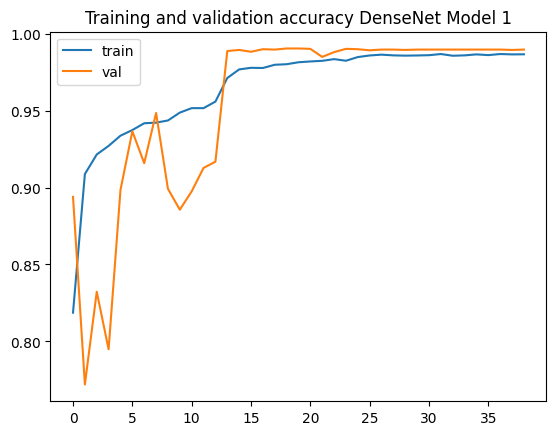

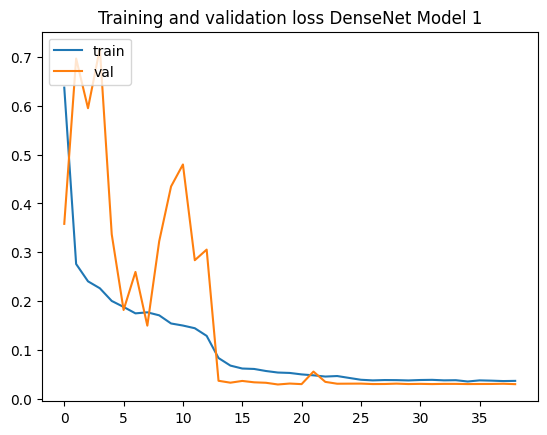

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
!zip -r /content/Tomato_DenseNet_model1_Based_Augmented.zip /content/Tomato_DenseNet_model1_Based_Augmented

  adding: content/Tomato_DenseNet_model1_Based_Augmented/ (stored 0%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/variables/ (stored 0%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/variables/variables.index (deflated 79%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/assets/ (stored 0%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Tomato_DenseNet_model1_Based_Augmented/saved_model.pb (deflated 92%)


DenseNet Model 2

In [7]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Tomato_DenseNet_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [8]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(9, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 7,302,217
Trainable params: 7,218,569
Non-t

In [9]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
860/860 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.8319
Epoch 1: val_accuracy improved from -inf to 0.54730, saving model to Tomato_DenseNet_model2_Based_Augmented


860/860 [==============================] - 485s 460ms/step - loss: 0.5061 - accuracy: 0.8319 - val_loss: 3.2091 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 2/100
860/860 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9106
Epoch 2: val_accuracy improved from 0.54730 to 0.92876, saving model to Tomato_DenseNet_model2_Based_Augmented


860/860 [==============================] - 382s 444ms/step - loss: 0.2736 - accuracy: 0.9106 - val_loss: 0.2471 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 3/100
860/860 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9281
Epoch 3: val_accuracy did not improve from 0.92876
860/860 [==============================] - 320s 371ms/step - loss: 0.2226 - accuracy: 0.9281 - val_loss: 1.2454 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 4/100
860/860 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9361
Epoch 4: val_accuracy did not improve from 0.92876
860/860 [==============================] - 320s 371ms/step - loss: 0.1944 - accuracy: 0.9361 - val_loss: 1.3503 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 5/100
860/860 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9384
Epoch 5: val_accuracy did not improve from 0.92876
860/860 [==============================] - 321s 373ms/step - loss: 0.1839 - accuracy: 0.9384 - val_loss: 0.6099 

860/860 [==============================] - 383s 446ms/step - loss: 0.0945 - accuracy: 0.9675 - val_loss: 0.0509 - val_accuracy: 0.9828 - lr: 1.0000e-04
Epoch 9/100
860/860 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9730
Epoch 9: val_accuracy improved from 0.98284 to 0.98690, saving model to Tomato_DenseNet_model2_Based_Augmented


860/860 [==============================] - 379s 440ms/step - loss: 0.0765 - accuracy: 0.9730 - val_loss: 0.0426 - val_accuracy: 0.9869 - lr: 1.0000e-04
Epoch 10/100
860/860 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9757
Epoch 10: val_accuracy did not improve from 0.98690
860/860 [==============================] - 312s 363ms/step - loss: 0.0672 - accuracy: 0.9757 - val_loss: 0.0485 - val_accuracy: 0.9831 - lr: 1.0000e-04
Epoch 11/100
860/860 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9780
Epoch 11: val_accuracy did not improve from 0.98690
860/860 [==============================] - 302s 351ms/step - loss: 0.0633 - accuracy: 0.9780 - val_loss: 0.0432 - val_accuracy: 0.9869 - lr: 1.0000e-04
Epoch 12/100
860/860 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9784
Epoch 12: val_accuracy improved from 0.98690 to 0.98785, saving model to Tomato_DenseNet_model2_Based_Augmented


860/860 [==============================] - 369s 429ms/step - loss: 0.0613 - accuracy: 0.9784 - val_loss: 0.0336 - val_accuracy: 0.9878 - lr: 1.0000e-04
Epoch 13/100
860/860 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9788
Epoch 13: val_accuracy improved from 0.98785 to 0.98904, saving model to Tomato_DenseNet_model2_Based_Augmented


860/860 [==============================] - 363s 422ms/step - loss: 0.0583 - accuracy: 0.9788 - val_loss: 0.0341 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 14/100
860/860 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.9805
Epoch 14: val_accuracy did not improve from 0.98904
860/860 [==============================] - 303s 352ms/step - loss: 0.0558 - accuracy: 0.9805 - val_loss: 0.0412 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 15/100
860/860 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9811
Epoch 15: val_accuracy did not improve from 0.98904
860/860 [==============================] - 305s 354ms/step - loss: 0.0519 - accuracy: 0.9811 - val_loss: 0.0407 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 16/100
860/860 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9801
Epoch 16: val_accuracy did not improve from 0.98904
860/860 [==============================] - 306s 356ms/step - loss: 0.0539 - accuracy: 0.9801 -

860/860 [==============================] - 362s 421ms/step - loss: 0.0382 - accuracy: 0.9864 - val_loss: 0.0395 - val_accuracy: 0.9893 - lr: 1.0000e-06
Epoch 27/100
860/860 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9850
Epoch 27: val_accuracy improved from 0.98928 to 0.98975, saving model to Tomato_DenseNet_model2_Based_Augmented



Epoch 27: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
860/860 [==============================] - 368s 428ms/step - loss: 0.0405 - accuracy: 0.9850 - val_loss: 0.0382 - val_accuracy: 0.9898 - lr: 1.0000e-06
Epoch 28/100
860/860 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9864
Epoch 28: val_accuracy did not improve from 0.98975
860/860 [==============================] - 305s 354ms/step - loss: 0.0392 - accuracy: 0.9864 - val_loss: 0.0388 - val_accuracy: 0.9893 - lr: 1.0000e-07
Epoch 29/100
860/860 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9856
Epoch 29: val_accuracy did not improve from 0.98975
860/860 [==============================] - 303s 353ms/step - loss: 0.0400 - accuracy: 0.9856 - val_loss: 0.0391 - val_accuracy: 0.9895 - lr: 1.0000e-07
Epoch 30/100
860/860 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9863
Epoch 30: val_accuracy improved from 0.98975 to 0.98999, saving mod

860/860 [==============================] - 372s 433ms/step - loss: 0.0385 - accuracy: 0.9863 - val_loss: 0.0384 - val_accuracy: 0.9900 - lr: 1.0000e-07
Epoch 31/100
860/860 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9863
Epoch 31: val_accuracy did not improve from 0.98999
860/860 [==============================] - 305s 355ms/step - loss: 0.0380 - accuracy: 0.9863 - val_loss: 0.0409 - val_accuracy: 0.9881 - lr: 1.0000e-07
Epoch 32/100
860/860 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9852
Epoch 32: val_accuracy did not improve from 0.98999

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
860/860 [==============================] - 310s 361ms/step - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0391 - val_accuracy: 0.9895 - lr: 1.0000e-07
Epoch 33/100
860/860 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9860
Epoch 33: val_accuracy did not improve from 0.98999
860/860 [=======

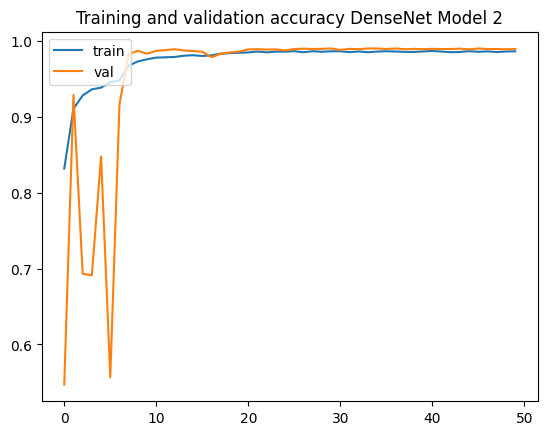

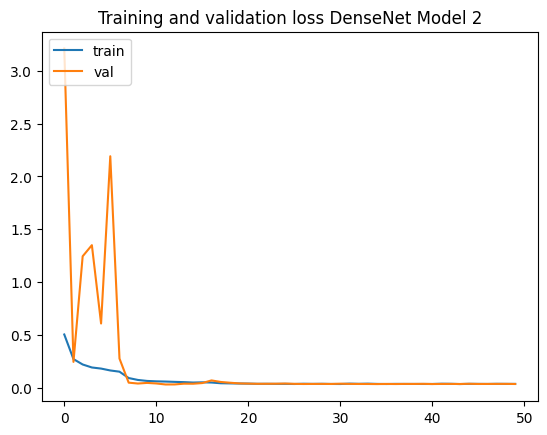

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
!zip -r /content/Tomato_DenseNet_model2_Based_Augmented.zip /content/Tomato_DenseNet_model2_Based_Augmented

  adding: content/Tomato_DenseNet_model2_Based_Augmented/ (stored 0%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/variables/ (stored 0%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/variables/variables.index (deflated 79%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/assets/ (stored 0%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/fingerprint.pb (stored 0%)
  adding: content/Tomato_DenseNet_model2_Based_Augmented/saved_model.pb